# Autocodificadores

<table align='left'>
<tr><td> <img src="../figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import OrderedDict

from PIL import Image
from IPython import display

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import lr_scheduler
import torchvision

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
x_train, y_train = torch.load('/data/datasets/MNIST/processed/training.pt')
x_test,  y_test  = torch.load('/data/datasets/MNIST/processed/test.pt')

In [3]:
print(x_train.shape, x_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## Treinando com pouquíssimos dados

In [4]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
else:
    n_train_samples = x_train.shape[0]
    n_test_samples  = x_test.shape[0]
xx_train = x_train[:n_train_samples].float() /255.
yy_train = y_train[:n_train_samples] 
xx_test  = x_test[:n_test_samples].float() / 255.
yy_test  = y_test[:n_test_samples]

In [5]:
xx_train.shape, xx_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
xx_train.type(),yy_train.type(), xx_test.type(), yy_test.type()

('torch.FloatTensor',
 'torch.LongTensor',
 'torch.FloatTensor',
 'torch.LongTensor')

## Cria a rede

<table align='left'>
<tr><td> <img src="../figures/autoencoder_1.png",width=600pt> </td></tr>
</table>

In [7]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(128, 2)
        self.dense4 = nn.Linear(2, 128)
        self.relu3 = nn.ReLU()
        self.dense5 = nn.Linear(128, 512)
        self.relu4 = nn.ReLU()
        self.dense6 = nn.Linear(512, 28*28)
    def encode(self, x):
        x = x.view(-1, 28*28)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        return x
    def decode(self, x):
        x = self.dense4(x)
        x = self.relu3(x)
        x = self.dense5(x)
        x = self.relu4(x)
        x = self.dense6(x)
        x = x.view(-1, 28, 28)
        return x
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [8]:
model = MyAutoEncoder()
print(model)

MyAutoEncoder (
  (dense1): Linear (784 -> 512)
  (relu1): ReLU ()
  (dense2): Linear (512 -> 128)
  (relu2): ReLU ()
  (dense3): Linear (128 -> 2)
  (dense4): Linear (2 -> 128)
  (relu3): ReLU ()
  (dense5): Linear (128 -> 512)
  (relu4): ReLU ()
  (dense6): Linear (512 -> 784)
)


## Cria o trainer

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
savebest = ptt.ModelCheckpoint('../../models/auto_encoder_pt',reset=True, verbose=1)
trainer = ptt.DeepNetTrainer( 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         callbacks = [savebest, ptt.PrintCallback()]
                        )

## Treinamento

In [10]:
retrain = False
if retrain:
    trainer.fit(n_epochs=20, Xin=xx_train, Yin=xx_train,
                valid_data=(xx_test, xx_test), batch_size=20)
else:
    trainer.load_state('/data/models/auto_encoder_pt')

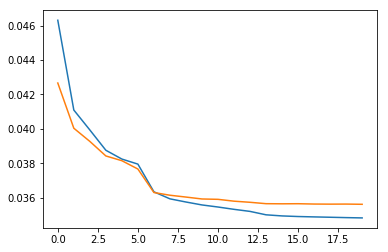

In [11]:
tra_loss = trainer.metrics['train']['losses']
val_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(tra_loss))
plt.plot(epochs, tra_loss, epochs, val_loss)

In [12]:
yy_pred = trainer.predict(xx_test)

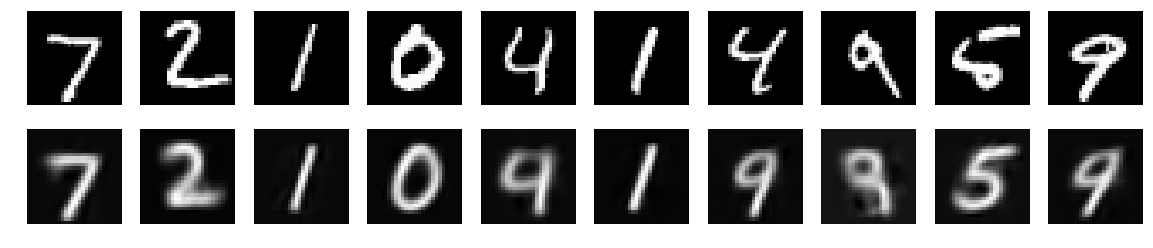

In [13]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xx_test[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(yy_pred[i].cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens no plano 2D

In [14]:
xin = Variable(xx_train.view(-1, 28*28))
if use_gpu:
    xin = xin.cuda()
encoded = trainer.model.encode(xin)
encoded_data = encoded.data.cpu().numpy()

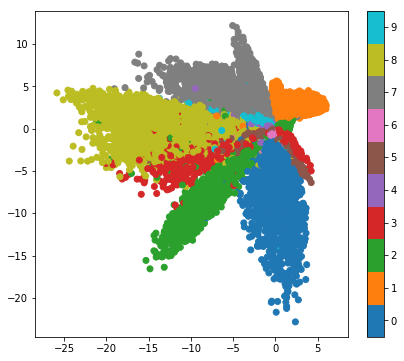

In [15]:
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

## Imagens geradas ao percorrer uma linha reta no espaço 2D

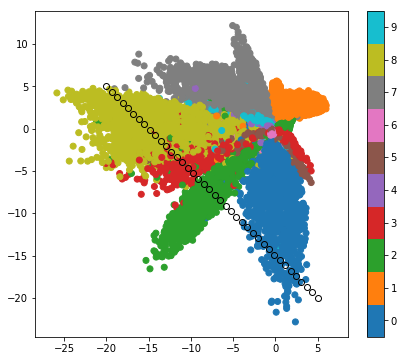

In [16]:
n = 40
x = np.linspace(-20.,   5., n)
y = np.linspace(  5., -20., n)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

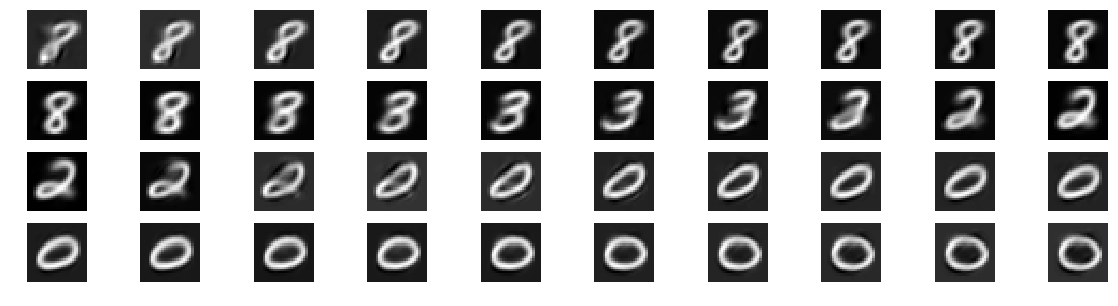

In [17]:
data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

data_in = Variable(data)
if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens geradas ao percorrer um círculo no espaço 2D centrado em (0,0)

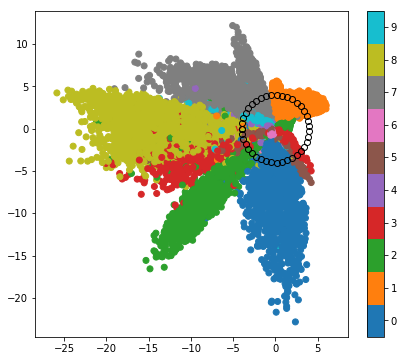

In [18]:
n = 40
phi = np.linspace(-np.pi, np.pi, n)
r = 4.
x = r * np.cos(phi)
y = r * np.sin(phi)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

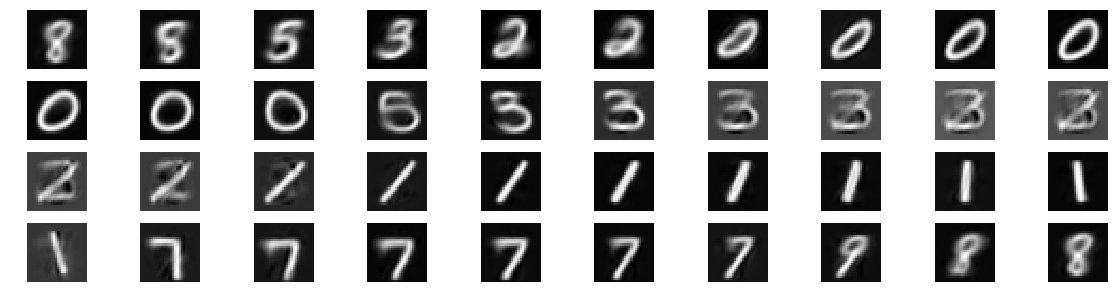

In [19]:
data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

data_in = Variable(data)
if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

# Atividades

## Exercícios

1. Escolha um código (duas coordenadas no espaço 2D mostrado acima), e utilize o decoder (model.decoder) para mostrar qual é a saída correspondente da rede treinada.
2. Aumente o número de imagens geradas para 100 tanto ao percorrer uma linha reta como para percorrer um círculo,
   nos exemplos gerados acima e observe a melhora na interpolação entre as imagens geradas.
3. Observe que no gráfico do espaço bidimensional do código da imagem, observa-se um código da classe 4 (roxo)
   posicionado na região dos códigos da classe 7 (cinza). Identifique qual é a imagem dentre o conjunto das
   amostras de `xx_train` que está anotada como pertencente à classe 4, porém aparece no espaço das imagens da
   classe 7.